## **SISTEMAS DE RECOMENDACIÓN**

En esta práctica abordaremos los aspectos centrales inherentes a los sistemas de recomendación.

En esencia, un sistema de recomendación (en adelante, "RS") es un algoritmo que predice la preferencia de los usuarios ante un cierto ítem.

En este punto, es importante introducir los dos elementos fundamentales en todo el proceso de RS: `usuarios` e `ítems`.

- - -

Los usuarios tienen preferencias para ciertos artículos, y estas preferencias deben extraerse de los datos. Los datos en sí se representan como una **`matriz de utilidad`**, dando para cada par usuario-ítem un valor que representa lo que se sabe sobre el grado de preferencia de ese usuario por ese artículo.

<img src = "matriz_utilidad.jpg" height = 150>

*Ejemplo de matriz de utilidad*.

En esta matriz, tenemos representadas las preferencias de cada usuario (A, B, C y D) para cada uno de los ítems (HP1, HP2, HP3, TW, SW1, SW2 y SW3). Podría asemejarse a una plataforma de streaming para películas -por supuesto que a una escala mucho más simplificada para fines prácticos-.

Esta matriz, como la mayoría de su tipo, es `dispersa`. Esto quiere decir que contiene muchos valores faltantes. Por ejemplo, el usuario B calificó las películas de Harry Potter. Pero no puede calificar absolutamente todas las películas disponibles en la plataforma. Probablemente no haya visto ni el 1% de todo el contenido que brinda un servicio de streaming como Netflix. 

Nuestro objetivo es predecir todos los valores desconocidos en la matriz de utilidad. 

A simple vista, uno podría inferir que si al usuario A no le gustó Star Wars 1, probablemente tampoco le gustará Star Wars 2 y Star Wars 3. Por otra parte, si tuviéramos en nuestra matriz el artículo Harry Potter 4, y el usuario B no la vio, las probabilidades de que le guste son altas. Por supuesto, el objetivo es hacer todas estas predicciones pero de manera sistemática, no manual.

- - -

### **`TIPOLOGÍA`**

Una vez completada la matriz de utilidad, existen diversas formas de realizar recomendaciones a los usuarios. Por un lado, un modelo benchmark clásico para estos casos consiste en recomendar los n-mejores ítems. Claro está, esta estrategia carece de personalización y segmentación de los usuarios y las preferencias. Recomienda, simplemente, por popularidad de los artículos.

### **Basados en contenidos**

Estos RS recomiendan a partir de la información extraída de los ítems. Para la matriz de utilidad que estuvimos viendo, basaría su recomendación en la información per se de la película -cuál es su director, quiénes actúan, a qué género pertenece, en qué año se estrenó, etc.-.

En este caso, se le recomendarán al usuario ítems que sean parecidos a los que calificó positivamente.

### **Filtro colaborativo**

Acá la similitud no se buscará entro los ítems, sino entre los usuarios. Ya no nos importa extraer información del artículo que recomendamos, sino buscar similaridad entre los usuarios. Puede pensarse como una regla de transitividad.

Emplea una descomposición UV.

Veamos, esquemáticamente, cuál es el fundamento de cada una de las estrategias:


<img src = "https://miro.medium.com/max/1064/1*mz9tzP1LjPBhmiWXeHyQkQ.png" height = 400>

- - -

### **`SIMILITUD`**

La pregunta que debemos responder ahora es, ¿cómo determinamos similitud?¿Con qué criterio establecemos que dos artículos, por ejemplo, son similares entre sí?

Este concepto está muy relacionado con la **distancia**.

#### ***Similitud coseno***

Una de las formas de obtener esta característica, entre ítems o usuarios, es con la `similitud coseno`. Esta estrategia determina la similaridad según el ángulo del vector.

|<img src = "https://www.tyrrell4innovation.ca/wp-content/uploads/2021/06/rsz_jenny_du_miword.png" height = 450> | <img src = "../_src/assets/RS.jpg" height = 300>|
|- |- |

#### ***Índice Jaccard***

Esta medida deriva de la teoría de los conjuntos. Lo que hace es determinar similaridad a partir de la cantidad de elementos en común que tienen los cojuntos -por ejemplo, los usuarios-.

|<img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTOlmfUP56ZbgwudKcjlXEc9os0Vwe7NO7wRA&usqp=CAU" height = 200>|

<img src = "https://storage.googleapis.com/lds-media/images/jaccard_similarity.width-1200.jpg" height = 400>

- - -

### `Práctica`

Trabajaremos con un [dataset](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data) de Netflix, disponibilizado por la compañía en ocasión de un Challenge que hicieron público. Aplicaremos un filtro colaborativo. Podrán observar que nos estamos enfrentando a un caso real, con una cantidad de datos altamente superior a lo que estamos acostumbrados a usar como ejemplos de prácticas.

En una primaria instancia, cargaremos solo uno de los archivos. Deberemos hacer un exhaustivo análisis exploratorio de los datos. Posteriormente, instanciaremos nuestro modelo con la librería `surprise` y, finalmente, mostraremos cómo incorporar los demás archivos disponibles.

Teniendo en cuenta el espacio en memoria que ocuparán nuestros datos, iremos aplicando diversas estrategias que, además, pueden ser de mucha utilidad a futuro para casos similares.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [28]:
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    
    # En algunas ocasiones forzar un tipo de dato hace que se ahorre mucho lugar en memoria.
    df['Rating'] = df['Rating'].astype(float)
    return df

df1 = load_data('../Datasets/combined_data_1.txt')
print(df1.shape)

(24058263, 2)


**Sí. Tenemos 24 millones de filas. Y es solo el primer archivo del dataset total, que está subdividido en 4 txt.**

<img src = "https://c.tenor.com/Je27rnxSMbMAAAAM/suspicious-the-simpsons.gif">

In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   User    object 
 1   Rating  float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [30]:
df1.head()

,User,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


**Para saber a qué película corresponde cada calificación, debemos importar el dataset que aporta dicha información.**

In [31]:
df_title = pd.read_csv('../Datasets/movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


In [32]:
movie_id = 5
print(df_title.loc[movie_id].Name)

The Rise and Fall of ECW


In [33]:
# Si queremos contar cuántos identificadores hay, vamos a usar la siguiente información: al lado del identificador de la película, la columna `Rating` de `df1` tiene un `NaN`.

movies_ids_df1 = df1.User[df1.Rating.isna()].values
print(movies_ids_df1)
print(len(movies_ids_df1))

['1:' '2:' '3:' ... '4497:' '4498:' '4499:']
4499


In [34]:
# Proceso para poder pasar los identificados a nombres

movies_ids_df1 = np.arange(1,len(movies_ids_df1) + 1)
print(movies_ids_df1)

[   1    2    3 ... 4497 4498 4499]


### **Movie id**

Aquí, buscaremos agregar una columna con el ID de la película a la que corresponde cada calificación.

In [35]:
df1_nan = pd.DataFrame(pd.isnull(df1.Rating))
df1_nan = df1_nan[df1_nan['Rating'] == True]
idx_movies_ids = df1_nan.index.values
print(idx_movies_ids)

[       0      548      694 ... 24056849 24057564 24057834]


Queremos crear un vector de tantas instancias como `df1`, donde en cada lugar esté el movie_id a cual corresponde la calificación. Como tenemos los índices donde está cada movie_id, podemos obtener cuántas calificaciones hay de cada película.

In [36]:
# Agregamos el índice de la última instancia del DataFrame

idx_movies_ids = np.append(idx_movies_ids,df1.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([ 548,  146, 2013, ...,  715,  270,  429], dtype=int64)

In [37]:
# Celda no apta para ansiosos

import time

comienzo = time.time()

columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df1[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))
    
tiempo = time.time() - comienzo

print(f'Tardó {round(tiempo)} segundos')

Tardó 474 segundos


In [38]:
# Incorporamos la columna al DataFrame

df1['movie_id'] = columna_movie_id
del columna_movie_id

df1.dropna(inplace = True)
df1['User'] = df1['User'].astype(int)
df1['movie_id'] = df1['movie_id'].astype(np.int16)
df1['Rating'] = df1['Rating'].astype(np.int8)

In [39]:
gc.collect()

10

In [40]:
# Observamos cómo quedó nuestra tabla

df1

,User,Rating,movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1
...,...,...,...
24058258,2591364,2,4499
24058259,1791000,2,4499
24058260,512536,5,4499
24058261,988963,3,4499


In [24]:
# Guardamos
switch = False #cambien acá si quieren guardarlo

if switch:
    df1.to_csv(r'\Datasets\combined_data_1_con_movie_id.csv', index= False)

- - -

### **Análisis Exploratorio de Datos**

In [20]:
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


In [41]:
df1 = pd.read_csv('\Datasets\combined_data_1_con_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

In [18]:
df1.dtypes

User        int64
Rating       int8
movie_id    int16
dtype: object

In [19]:
df_title

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW
...,...
17766,Where the Wild Things Are and Other Maurice Se...
17767,Fidel Castro: American Experience
17768,Epoch


In [20]:
# Usuarios únicos

print(len(df1['User'].unique()))

470758


In [21]:
# Calificaciones de películas por usuario

df1_by_users = df1.groupby(['User']).count()
df1_by_users.head()

,Rating,movie_id
User,,
6,153,153
7,195,195
8,21,21
10,49,49
25,4,4


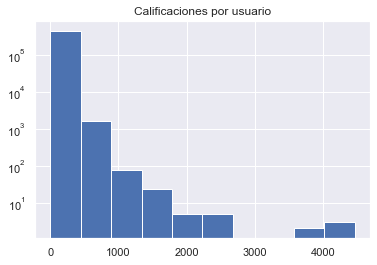

In [22]:
plt.hist(df1_by_users.Rating, log= True)
plt.title('Calificaciones por usuario')
plt.show()

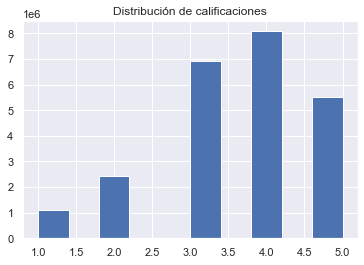

In [23]:
# Observamos la distribución de las calificaciones

df1['Rating'].hist()
plt.title('Distribución de calificaciones')
plt.show()

**Veamos cuál es la película que más calificaciones tiene y cuál la que menos**.

In [24]:
df1_by_movies = df1.groupby(['movie_id']).count()
df1_by_movies.head()

,User,Rating
movie_id,,
1,547,547
2,145,145
3,2012,2012
4,142,142
5,1140,1140


In [25]:
idx_max = df1_by_movies['User'].idxmax()
print(df_title.loc[idx_max].Name)

Pirates of the Caribbean: The Curse of the Black Pearl


In [26]:
# Pelicula con menos calificaciones
idx_min = df1_by_movies['User'].idxmin()
print(df_title.loc[idx_min].Name)

Bram Stoker's: To Die For


### **Películas por popularidad**

In [27]:
df1_by_movies = df1.groupby(['movie_id']).count()
df1_by_movies.sort_values('User', ascending = False, inplace = True)
df1_by_movies['Vistos'] = df1_by_movies['User']
df1_by_movies.drop(columns = ['User','Rating'], inplace = True)
df1_by_movies.head(10)

,Vistos
movie_id,
1905,193941
2152,162597
3860,160454
4432,156183
571,154832
3938,153996
4306,151292
2452,149866
1962,145519


In [28]:
df_title.head(3)

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character


In [29]:
df1_by_movies['Titulo'] = df_title.loc[df1_by_movies.index].Name

In [30]:
df1_by_movies.head()

,Vistos,Titulo
movie_id,,
1905,193941,Pirates of the Caribbean: The Curse of the Bla...
2152,162597,What Women Want
3860,160454,Bruce Almighty
4432,156183,The Italian Job
571,154832,American Beauty


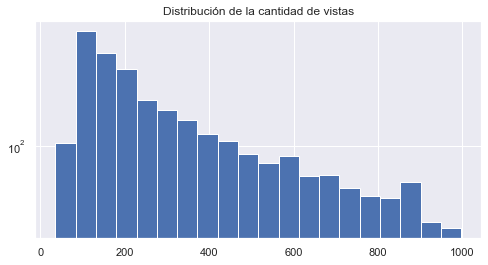

In [31]:
plt.figure(figsize = (8,4))

df1_by_movies.Vistos[df1_by_movies.Vistos<1000].hist(log = True, bins = 20)
plt.title('Distribución de la cantidad de vistas')

plt.show()

En esta etapa, lo que haremos será filtrar de nuestro dataset a aquellas películas con pocas calificaciones. Para ello, establecemos un umbral.

In [32]:
umbral = 1000
mascara_pocos_vistos = df1_by_movies.Vistos<umbral

In [33]:
peliculas_pocos_vistos = mascara_pocos_vistos[mascara_pocos_vistos].index.values
print(len(peliculas_pocos_vistos), peliculas_pocos_vistos)

2757 [1817  806 3486 ... 3656 4338 4362]


In [34]:
mascara_descartables = df1.movie_id.isin(peliculas_pocos_vistos)

In [35]:
# Obsevamos cómo cambia la cantidad de registros a partir del filtrado

print(df1.shape)
df1 = df1[~mascara_descartables]
print(df1.shape)

(24053764, 3)
(23163063, 3)


## **`Machine Learning`**

Para trabajar con sistemas de recomendación, emplearemos la librería `Surprise` de la que dejamos [aquí](https://surprise.readthedocs.io/en/stable/) la documentación.

Tendremos que llevar nuestro dataset al formato con el que trabaja esta librería.

In [ ]:
import sys
!conda activate henry-bootcamp
!conda install -c conda-forge scikit-surprise 
#from scikit.surprise import Dataset
#from surprise import Reader
#from surprise.model_selection import train_test_split

In [74]:
reader = Reader()

In [75]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df1[['User', 'movie_id', 'Rating']][:N_filas], reader)

In [76]:
# Separamos nuestros datos

trainset, testset = train_test_split(data, test_size=.25)

In [80]:
# Usaremos un modelo de Singular Value Decomposition

from surprise import SVD
model = SVD()

In [81]:
# Entrenamos el modelo

model.fit(trainset)

In [83]:
# Predecimos

predictions = model.test(testset)

In [84]:
predictions[1]

Prediction(uid=2219491, iid=28, r_ui=4.0, est=3.8249210765751536, details={'was_impossible': False})

In [85]:
# Hacemos una predicción al azar para usuario y película

model.predict(1328945,28)

Prediction(uid=1328945, iid=28, r_ui=None, est=3.8249210765751536, details={'was_impossible': False})

In [86]:
# Tomaremos un usuario para hacerle una recomendación

usuario = 1539350
rating = 4   # Tomamos películas a las que haya calificado con 4 o 5 estrellas
df_user = df1[(df1['User'] == usuario) & (df1['Rating'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['Name'] = df_title['Name'].loc[df_user.movie_id].values
df_user

,User,Rating,movie_id,Name
0,1539350,4,111,Duplex (Widescreen)
1,1539350,4,175,Reservoir Dogs
2,1539350,4,197,Taking Lives
3,1539350,5,269,Parenthood
4,1539350,5,270,Sex and the City: Season 4
5,1539350,4,367,Spun
6,1539350,5,406,Hostage
7,1539350,4,457,Kill Bill: Vol. 2
8,1539350,4,692,The Hand that Rocks the Cradle
9,1539350,4,758,Mean Girls


In [87]:
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


In [89]:
# Debemos extraer las películas que ya ha visto

usuario_vistas = df1[df1['User'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(97, 3)


,User,Rating,movie_id
219870,1539350,3,33
409717,1539350,4,111
445206,1539350,3,127
664099,1539350,4,175
894718,1539350,4,197


In [90]:
if True: # Sacamos las que filtramos
    recomendaciones_usuario.drop(peliculas_pocos_vistos, inplace = True)

In [91]:
recomendaciones_usuario.drop(usuario_vistas.movie_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,Movie_Id,Name
0,3,Character
1,5,The Rise and Fall of ECW
2,6,Sick
3,8,What the #$*! Do We Know!?
4,16,Screamers


In [93]:
# Recomendamos

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['Movie_Id'].apply(lambda x: model.predict(usuario, x).est)

In [94]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

      Movie_Id                                           Name  Estimate_Score
8           25  Inspector Morse 31: Death Is Now My Neighbour        3.993816
1            5                       The Rise and Fall of ECW        3.922796
6           18                               Immortal Beloved        3.828125
10          28                                Lilo and Stitch        3.824921
11          30                         Something's Gotta Give        3.675472
0            3                                      Character        3.642784
1102      3054                                 I'm Not Scared        3.549960
1101      3047                        The Fabulous Baker Boys        3.549960
1094      3023                                       Upstairs        3.549960
1100      3046              The Simpsons: Treehouse of Horror        3.549960


### **Evaluación**

In [95]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.0357


1.0356704607271807

### **Optimización de hiperparámetros**

In [98]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0425  1.0346  1.0411  1.0394  0.0034  
Fit time          1.45    1.45    1.42    1.44    0.01    
Test time         0.50    0.26    0.46    0.41    0.10    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0423  1.0374  1.0376  1.0391  0.0023  
Fit time          1.09    0.97    1.01    1.02    0.05    
Test time         0.17    0.17    0.17    0.17    0.00    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0379  1.0422  1.0401  1.0401  0.0018  
Fit time          1.05    1.01    1.02    1.02    0.02    
Test time         0.16    0.16    0.17    0.16    0.00    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0443  1.0

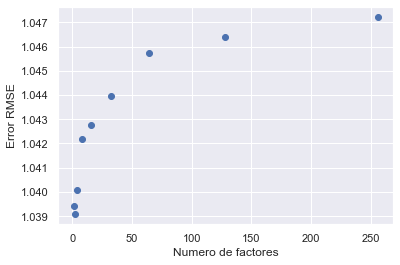

In [99]:
# Ploteamos desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [100]:
# Nuevamente, no apto para ansiosos

from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [101]:
# Observamos performance del mejor modelo

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0402300239724742
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


Para entender un poco más estas métricas podemos irnos [aquí](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

- - -

## **Incorporación de nuevos datos**

Vamos a ver cómo sumar las calificaciones que no hemos usado.

In [102]:
# 1

def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    
    # En ciertos casos, forzar un tipo de dato hace que se ahorre mucho lugar en memoria.
    df['Rating'] = df['Rating']#.astype(float) 
    return df


df2 = load_data('../Datasets/combined_data_2.txt')
print(df2.shape)

(26982302, 2)


In [103]:
# 2

movies_ids_df2 = df2.User[df2.Rating.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

['4500:' '4501:' '4502:' ... '9208:' '9209:' '9210:']
4711
[4500 4501 4502 ... 9208 9209 9210]


In [104]:
df2_nan = pd.DataFrame(pd.isnull(df2.Rating))
df2_nan = df2_nan[df2_nan['Rating'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

[       0      259      855 ... 26961403 26980373 26980497]


In [105]:
# Agregamos el índice de la última instancia del DataFrame

idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])

In [106]:
cantidad_criticas = np.diff(idx_movies_ids)

In [107]:
cantidad_criticas

array([  259,   596,   105, ..., 18970,   124,  1805], dtype=int64)

In [108]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [109]:
df2['movie_id'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['User'] = df2['User'].astype(int)
df2['movie_id'] = df2['movie_id'].astype(np.int16)
df2['Rating'] = df2['Rating'].astype(np.int8)

gc.collect()

2493

In [110]:
df2

,User,Rating,movie_id
1,2532865,4,4500
2,573364,3,4500
3,1696725,3,4500
4,1253431,3,4500
5,1265574,2,4500
...,...,...,...
26982297,2420260,1,9210
26982298,761176,3,9210
26982299,459277,3,9210
26982300,2407365,4,9210


In [111]:
### 4.

df1 = pd.read_csv('../Datasets/combined_data_1_con_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [112]:
### 5.
df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

C:\Users\leand\AppData\Local\Temp\ipykernel_54968\395377864.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2)


(51031355, 3)


In [113]:
# Corroboramos que estén todas las películas

peliculas_presentes = df.movie_id.unique()
peliculas_presentes

array([   1,    2,    3, ..., 9208, 9209, 9210], dtype=int16)

In [114]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

0


In [115]:
switch = False
if switch:
    df.to_csv('../Datasets/combined_data_1y2_con_movie_id.csv', index= False)

- - -